이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [10]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [12]:
# 요약
## 요약전에 이미지 28x28(2차원)을 1차원 벡터(flat)로 바꿔줌
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [14]:
## 1차원 벡터로 바꿔준 데이터들을 df로 변환후 describe() 사용
df_train = pd.DataFrame(X_train_flat)
print(df_train.describe())

                0             1             2             3             4    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000800      0.005783      0.030083      0.103800      0.249683   
std        0.092554      0.249033      0.767868      2.512017      4.331376   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       16.000000     36.000000    119.000000    164.000000    224.000000   

                5             6             7             8             9    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.414717      0.821667      2.224733      5.698667     14.434650   
std        5.827394      8.309935     14.201820    

In [18]:
df_test = pd.DataFrame(X_test_flat)
print(df_test.describe())

               0            1             2             3             4    \
count  10000.00000  10000.00000  10000.000000  10000.000000  10000.000000   
mean       0.00060      0.01020      0.060900      0.069400      0.236800   
std        0.04472      0.49368      2.560634      2.111973      4.843271   
min        0.00000      0.00000      0.000000      0.000000      0.000000   
25%        0.00000      0.00000      0.000000      0.000000      0.000000   
50%        0.00000      0.00000      0.000000      0.000000      0.000000   
75%        0.00000      0.00000      0.000000      0.000000      0.000000   
max        4.00000     45.00000    218.000000    185.000000    227.000000   

               5             6             7             8           9    ...  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.0000  ...   
mean       0.37270      0.690300      2.082300      5.252300     14.2621  ...   
std        5.93103      7.401964     13.598537     22.856331   

In [20]:
# 모양 (train은 6만, test는 1만, 둘다 28x28)
print('X_train shape = ',X_train.shape)
print('y_train shape = ',y_train.shape)
print('X_test shape = ',X_test.shape)
print('y_test shape = ',y_test.shape)

X_train shape =  (60000, 28, 28)
y_train shape =  (60000,)
X_test shape =  (10000, 28, 28)
y_test shape =  (10000,)


In [22]:
# 크기
print('X_train size =', len(X_train)) 
print('y_train size =',len(y_train)) 
print('X_test size =',len(X_test)) 
print('y_test size =',len(y_test)) 

X_train size = 60000
y_train size = 60000
X_test size = 10000
y_test size = 10000


In [24]:
# 결측치
missing_values_train = df_train.isnull().sum().sum()
missing_values_test = df_test.isnull().sum().sum()
print(missing_values_train)
print(missing_values_test)

0
0


### Data중 첫 번째 이미지를 보여주세요.

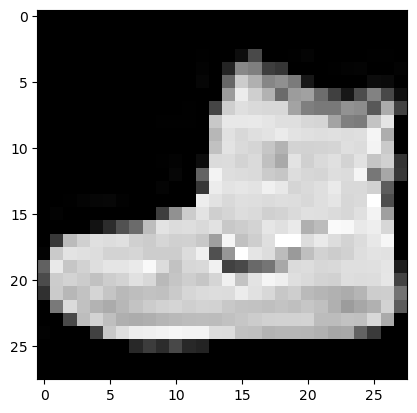

In [27]:
plt.imshow(X_train[0],cmap="gray")
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어야 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [31]:
# 이미지와 레이블을 텐서로 변환하고 정규화 수행
X_train_images = torch.tensor(X_train, dtype=torch.float32)
y_train_labels = torch.tensor(y_train, dtype=torch.long)
X_test_images = torch.tensor(X_test, dtype=torch.float32)
y_test_labels = torch.tensor(y_test, dtype=torch.long)

# TensorDataset 생성
train_dataset = TensorDataset(X_train_images, y_train_labels)
test_dataset = TensorDataset(X_test_images, y_test_labels)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터셋 형태 출력
print("Train images shape:", X_train_images.shape) 
print("Train labels shape:", y_train_labels.shape) 
print("Test images shape:", X_test_images.shape)    
print("Test labels shape:", y_test_labels.shape)     

# 변환된 텐서 확인 (예: 첫 번째 이미지와 레이블)
print("First image tensor:", X_train_images[0])
print("First label tensor:", y_train_labels[0])

Train images shape: torch.Size([60000, 28, 28])
Train labels shape: torch.Size([60000])
Test images shape: torch.Size([10000, 28, 28])
Test labels shape: torch.Size([10000])
First image tensor: tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.,   0.,   0.,  13.,  73.,   0.,   0.,   1.,   4.,   0.,   0.,   0.,
           0.,   1.,   1.,   0.],
        [  0.,   0.,  

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [34]:
X_train_normalized = X_train_images / 255.0
X_test_normalized = X_test_images / 255.0

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

둘다 고차원인 데이터를 저차원으로 축소하여 데이터를 분석하고 시각화하는데 도움을 주는 방법이다.

-PCA: 선형변환으로 차원을 축소한다. 차원을 축소하는 과정에서 데이터의 분산과 전체적인 구조가 비교적 유지되는 편이다.
-t-sne: 비선형 차원 축소 기법이다. 차원을 축소하는 과정에서 데이터 사이의 값 차이를 보존하려하는 방식이기 때문에 국소적 유사성이 비교적 유지되며 시각화할때 비교적 유리하다.

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [42]:
# 1차원 벡터화
X_flattened = X_train_images.reshape(X_train_images.shape[0], -1)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# PCA 적용 -- 50개
pca = PCA(n_components=50)
X_pca_50 = pca.fit_transform(X_scaled)
print(X_flattened.shape)
print("Transformed shape after PCA:", X_pca_50.shape)

torch.Size([60000, 784])
Transformed shape after PCA: (60000, 50)


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [44]:
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[0.22083547 0.14414633 0.05461176 0.05088686 0.04054887 0.03019511
 0.02747539 0.02313654 0.01692637 0.01318043 0.01170103 0.00962364
 0.00906441 0.00861006 0.00743008 0.00730325 0.00661558 0.00631515
 0.00621938 0.00584283 0.00523388 0.00511121 0.00473533 0.0045008
 0.00438704 0.00417086 0.0039834  0.00390545 0.00377665 0.00373526
 0.00363118 0.00351621 0.00336042 0.00330925 0.00328043 0.00317505
 0.00305205 0.00296661 0.00284695 0.00283068 0.00275586 0.00268136
 0.00262373 0.0025453  0.00247522 0.00240242 0.00237975 0.00228378
 0.00222071 0.00216055]


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [48]:
# PCA 역변환 (원본 차원으로 복원)
X_reconstructed = pca.inverse_transform(X_pca_50)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)

Reconstruction Error (MSE): 0.1992940538949516


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [51]:
pca = PCA(n_components=30)
X_pca_30 = pca.fit_transform(X_scaled)

print("Transformed shape_30:", X_pca_30.shape)

Transformed shape_30: (60000, 30)


In [52]:
explained_variance_ratio_30 = pca.explained_variance_ratio_

X_30_reconstructed = pca.inverse_transform(X_pca_30)
RE_30 = mean_squared_error(X_scaled, X_30_reconstructed)

print(explained_variance_ratio_30)
print("Reconstruction Error_30:", RE_30)

[0.22083547 0.14414633 0.05461176 0.05088686 0.04054887 0.03019511
 0.02747539 0.02313654 0.01692637 0.01318043 0.01170103 0.00962364
 0.00906441 0.00861006 0.00743008 0.00730325 0.00661558 0.00631515
 0.00621938 0.00584283 0.00523388 0.00511121 0.00473533 0.0045008
 0.00438704 0.00417086 0.0039834  0.00390545 0.00377665 0.00373526]
Reconstruction Error_30: 0.2557915680764573


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

차원수를 높게 줄일 수록 R.E가 낮은 것을 보니 원본 데이터와 차이가 덜 난다는 것을 알 수 있음

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [58]:
pca = PCA(n_components=2)
X_pca_2 = pca.fit_transform(X_scaled)

print("Transformed shape_30:", X_pca_2.shape)

Transformed shape_30: (60000, 2)


In [59]:
explained_variance_ratio_2 = pca.explained_variance_ratio_

X_2_reconstructed = pca.inverse_transform(X_pca_2)
RE_2 = mean_squared_error(X_scaled, X_2_reconstructed)

print(explained_variance_ratio_2)
print("Reconstruction Error_2:", RE_2)

[0.22083547 0.14414633]
Reconstruction Error_2: 0.6350182008929813


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

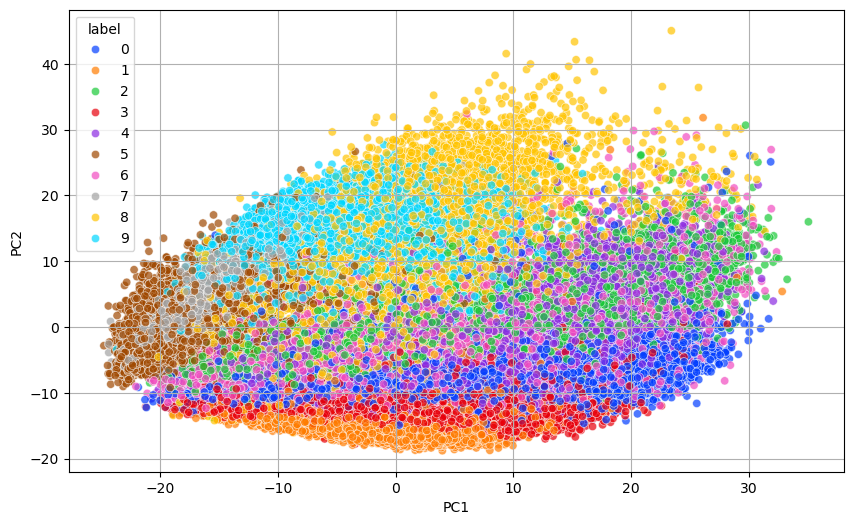

In [63]:
# 시각화
plt.figure(figsize=(10, 6))
pca2_df = pd.DataFrame(X_pca_2)
pca2_df.columns = ['PC1', 'PC2']
pca2_df['label'] = y_train
sns.scatterplot(data=pca2_df, x ='PC1', y='PC2', hue='label', alpha=0.7, palette='bright')
plt.grid()
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [44]:
# 2차원 변환
tsne_50 = TSNE(n_components=2, random_state=42, perplexity=25)
X_tsne_50 = tsne_50.fit_transform(X_pca_50)

# 시각화
plt.figure(figsize=(10, 6))
tsne_50_df = pd.DataFrame(X_tsne_50)
tsne_50_df.columns = ['Dim1', 'Dim2']
tsne_50_df['label'] = y_train

sns.scatterplot(data=tsne_50_df, x ='Dim1', y='Dim2', hue='label', alpha=0.7, palette='bright')
plt.grid()
plt.show()

KeyboardInterrupt: 

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [ ]:
tsne_30 = TSNE(n_components=2, random_state=42, perplexity=25)
X_tsne_30 = tsne_30.fit_transform(X_pca_30)

# 시각화
plt.figure(figsize=(10, 6))
tsne_30_df = pd.DataFrame(X_tsne_30)
tsne_30_df.columns = ['Dim1', 'Dim2']
tsne_30_df['label'] = y_train

sns.scatterplot(data=tsne_30_df, x ='Dim1', y='Dim2', hue='label', alpha=0.7, palette='bright')
plt.grid()
plt.show()

In [ ]:
### 여기 tsne 시각화부터 컴퓨터 성능 이슈로 시각화가 안됨

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=20, min_samples=5) # eps: 주변과의 거리의 최대값 min_samples: 주변으로 볼 최소의 수
dbscan_labels = dbscan.fit_predict(X_pca_50)

cluster_df = pd.DataFrame(X_pca_50, columns=[f'PC{i+1}' for i in range(50)])
cluster_df['DBSCAN_cluster'] = dbscan_labels.labels_

# 클러스터 결과 확인
cluster_df['DBSCAN_cluster'].value_counts()

### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [75]:
kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(X_pca_50)
cluster_df['kmeans_cluster'] = kmeans.labels_
cluster_df['kmeans_cluster'].value_counts()

kmeans_cluster
1    10707
3     9660
5     9207
6     7480
9     6553
8     4968
2     4036
0     2576
7     2518
4     2295
Name: count, dtype: int64

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

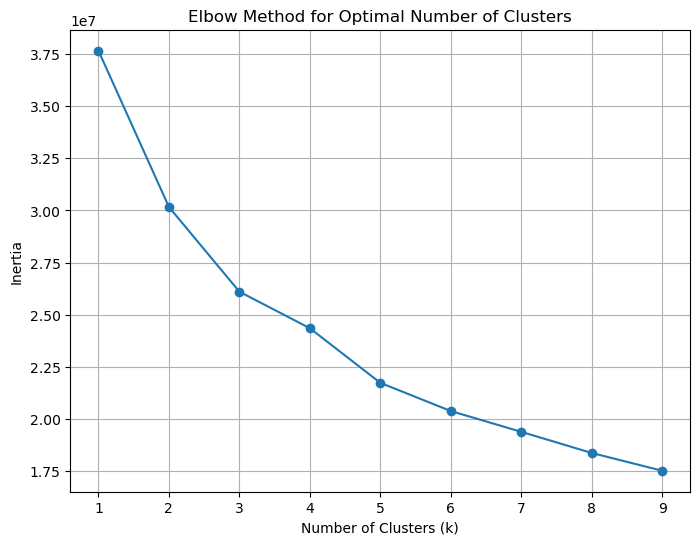

In [81]:
num_clusters = range(1, 10)
inertia = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca_50)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(num_clusters, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(num_clusters)
plt.grid(True)
plt.show()

In [93]:
# 엘보우 포인트 찾기: inertia의 변화율 계산
inertia_diff = np.diff(inertia)  
inertia_diff2 = np.diff(inertia_diff)  # SSD 차분 2번

# 엘보우 포인트의 인덱스 찾기
elbow_index = np.argmax(inertia_diff2) + 1  # 2차 차분 후 값이 최대인 인덱스 찾음
optimal_k = elbow_index + 1  # k는 1부터 시작하므로 0 시작인 인덱스에 1을 더함

print(f'Optimal K based on Elbow Method: {optimal_k}')

Optimal K based on Elbow Method: 2


### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

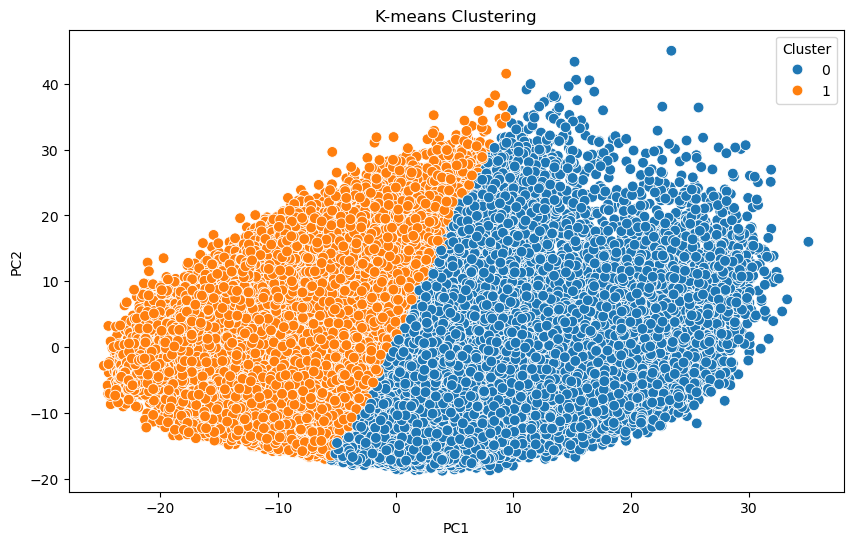

In [91]:
kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(X_pca_50)

cluster_df['kmeans_cluster'] = kmeans_2.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='tab10', s=60)
plt.title("K-means Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [132]:
from sklearn.metrics import silhouette_score

# DBSCAN에서 노이즈 제외하고 실루엣 점수 계산
unique_labels = set(dbscan_labels) - {-1} 
if len(unique_labels) > 1:  # 2개 이상의 군집이 존재할 경우에만 실루엣 점수 계산
    dbscan_silhouette = silhouette_score(X_pca_50[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    dbscan_silhouette = -1  # 군집이 하나이거나 노이즈만 있는 경우

dbscan_silhouette

-1

In [136]:
kmeans_silhouette = silhouette_score(X_pca_50, kmeans_labels)
kmeans_silhouette

0.1898010273547183

### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

Kmeans 방법은 0에 가까운 값이 나오면서 좋은 군집화 성능을 보여주었다.